## Introduction
Shopping can be hard for women. From inconsistent sizing to overwhelming options, finding the perfect fit is often a difficult task. The same size could mean different things across different brands. How stressful is this!

In this project, we use clothing fit datasets from ModCloth and RentTheRunway to predict whether an item will fit a user as ‘small’, ‘fit’, or ‘large’ to understand which user and item features are most informative for predicting fit and creating accurate recommendations across various clothing categories.

In [89]:
# Imports
import gzip
import json
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, precision_recall_fscore_support,
                             make_scorer, f1_score)

In [62]:
# Helper function to open data
def open_file_df(path):
    rows = []
    with gzip.open(path, 'rt', encoding='utf-8') as f:
        for line in f:
            rows.append(json.loads(line))

    df = pd.DataFrame(rows)
    return df

In [63]:
# Load in data
df_rent = open_file_df('data/renttherunway_final_data.json.gz')
df_mod = open_file_df('data/modcloth_final_data.json.gz')

In [64]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,category,height,size,age,review_date
0,fit,420272,34d,2260466,137lbs,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,romper,"5' 8""",14,28,"April 20, 2016"
1,fit,273551,34b,153475,132lbs,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,gown,"5' 6""",12,36,"June 18, 2013"
2,fit,360448,NaN,1063761,NaN,10,party,This hugged in all the right places! It was a ...,NaN,It was a great time to celebrate the (almost) ...,sheath,"5' 4""",4,116,"December 14, 2015"
3,fit,909926,34c,126335,135lbs,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,dress,"5' 5""",8,34,"February 12, 2014"
4,fit,151944,34b,616682,145lbs,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,gown,"5' 9""",12,27,"September 26, 2016"


In [65]:
df_mod.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29,7,5.0,d,38,34,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,30,36,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,NaN,32,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.00,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


## Preprocessing

We start with cleaning the RentTheRunway data.

In [66]:
# Deal with string cols
str_cols = ["fit", "bust size", "rented for", "review_text","body type", "review_summary", "category"]
df_rent[str_cols] = df_rent[str_cols].astype("string")

# Deal with int cols
int_cols = ["user_id", "item_id", "rating", "size", "age"]
for col in int_cols:
    df_rent[col] = pd.to_numeric(df_rent[col], errors='coerce').astype("Int64")

In [67]:
# Weight col
df_rent["weight"] = (df_rent["weight"].astype("string").str.extract(r"(\d+)", expand=False) .astype("float"))

# Height col helper function
def parse_height(x):
    if not isinstance(x, str):
        return np.nan

    # extract feet and inches
    m = re.match(r"^\s*(\d+)'\s*(\d+)?", x)
    if not m:
        return np.nan

    feet = float(m.group(1))
    inches = float(m.group(2)) if m.group(2) else 0.0

    return feet * 12 + inches

# Apply height cleaning function
df_rent["height_inches"] = df_rent["height"].apply(parse_height)

In [68]:
# Convert bust size to number(band) and letter(cup)

# Band col
df_rent["bust_band"] = (df_rent["bust size"].str.extract(r"(\d+)", expand=False).astype("float"))

# Cup col
df_rent["bust_cup"] = (df_rent["bust size"].str.extract(r"([a-zA-Z]+)", expand=False).str.upper())

# Date col - use pd datetime
df_rent["review_date"] = pd.to_datetime(df_rent["review_date"], errors="coerce")

In [69]:
# Convert "cocktail" category in rented for column into "party"
df_rent['rented_for'] = df_rent['rented for'].replace('party: cocktail', 'party')

In [70]:
# Drop rows with age > 100
df_rent = df_rent[df_rent.age <= 100]

# Drop rows with age == 0
df_rent = df_rent[df_rent.age != 0]

# Drop rows with size > 40
df_rent = df_rent[df_rent['size'] <= 40]

In [71]:
# Convert fit into numerical labels
fit_dict={'fit':0, 'small':-1, 'large':1}
df_rent.fit = df_rent.fit.apply(lambda x: fit_dict[x])

In [72]:
# Reduce categories from 68 to 10

# 10 categories definition
category_groups = {
    "dress": [
        "dress", "gown", "ballgown", "sheath", "shirtdress",
        "shift", "frock", "maxi", "mini", "midi"
    ],
    "jumpsuit/romper": [
        "jumpsuit", "romper", "overalls", "combo"
    ],
    "top": [
        "top", "blouse", "shirt", "tank", "tee", "t-shirt",
        "cami", "henley", "buttondown", "turtleneck", "blouson"
    ],
    "knitwear": [
        "sweater", "pullover", "knit", "cardigan", "crewneck",
        "hoodie", "sweatshirt", "sweatershirt"
    ],
    "pants": [
        "pants", "pant", "trouser", "trousers", "leggings",
        "legging", "jogger", "jeans", "culottes", "culotte",
        "sweatpants", "tight"
    ],
    "skirt": [
        "skirt", "skirts", "skort"
    ],
    "outerwear": [
        "jacket", "coat", "peacoat", "trench", "bomber",
        "blazer", "vest", "duster", "cape", "parka",
        "overcoat", "down"
    ],
    "ethnic/flowy": [
        "kaftan", "caftan", "kimono", "tunic", "poncho"
    ],
    "suit": ["suit"]
}

# make the map
category_map = {}
for new_cat, old_list in category_groups.items():
    for old_cat in old_list:
        category_map[old_cat] = new_cat

# apply mapping and set 'other' for unmapped
df_rent["category_clean"] = df_rent["category"].map(category_map).fillna("misc")


In [73]:
# Review text

In [74]:
#do this during pre processing for the model

cup_order = ["AA", "A", "B", "C", "D", "DD", "DDD", "E", "F", "G"]
#df_rent["bust_cup"] = pd.Categorical(df_rent["bust_cup"],categories=cup_order,ordered=True)

In [75]:
df_rent['fit_label'] = df_rent['fit'].map({-1: "small", 0: "fit", 1: "large"})
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,height_inches,bust_band,bust_cup,rented_for,category_clean,fit_label
0,0,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28,2016-04-20,68.0,34.0,D,vacation,jumpsuit/romper,fit
1,0,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36,2013-06-18,66.0,34.0,B,other,dress,fit
3,0,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34,2014-02-12,65.0,34.0,C,formal affair,dress,fit
4,0,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27,2016-09-26,69.0,34.0,B,wedding,dress,fit
5,0,734848,32b,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45,2016-04-30,68.0,32.0,B,date,dress,fit


now cleaning modcloth dataset

## EDA - RentTheRunway

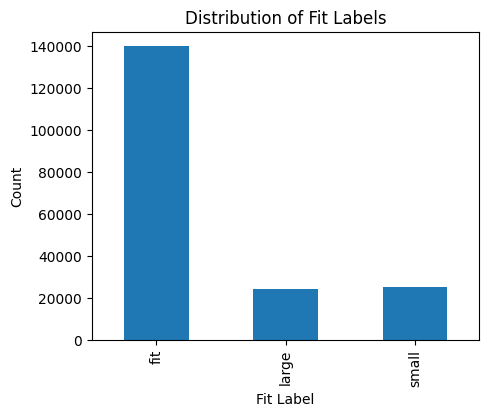

In [76]:
# Distribution of fit labels
plt.figure(figsize=(5,4))
df_rent['fit_label'].value_counts().sort_index().plot(kind='bar')
plt.title("Distribution of Fit Labels")
plt.xlabel("Fit Label")
plt.ylabel("Count")
plt.show()

The bar chart above shows a class imbalance with the majority of items fitting correctly, while "small" and "large" fit issues each represent only a small number of cases, which will require careful handling during model training to avoid biased predictions toward the majority "fit" class.

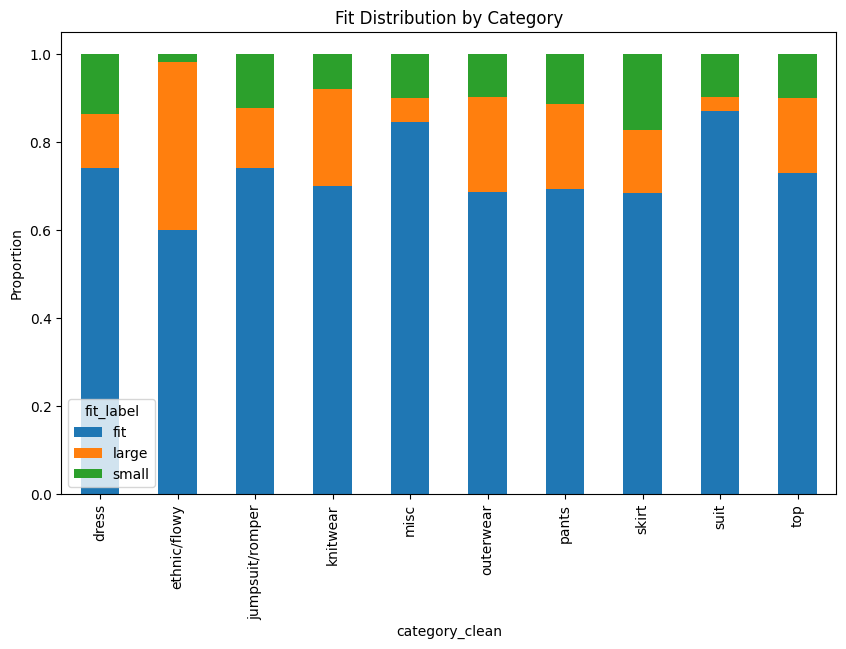

In [77]:
# Fit distribution by category
fit_by_cat = df_rent.groupby("category_clean")['fit_label'].value_counts(normalize=True).unstack()
fit_by_cat.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Fit Distribution by Category")
plt.ylabel("Proportion")
plt.show()

Fit proportions vary moderately across clothing categories, with ethnic/flowy items showing the highest rate of large fit issues while suits have the highest fit rate, suggesting that category-specific features will be important predictors in the model.

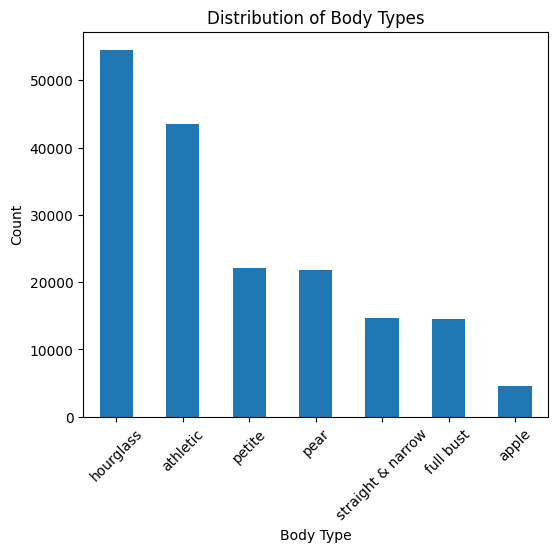

In [78]:
# Body type distribution
plt.figure(figsize=(6,5))
df_rent["body type"].value_counts().plot(kind="bar")
plt.title("Distribution of Body Types")
plt.xlabel("Body Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

The chart above shows that the data is dominated by hourglass (~56,000) and athletic (~43,000) body types, with petite, pear, full bust, and straight & narrow body types moderately represented, and apple body type is significantly underrepresented (~5,000). This creates an imbalanced distribution that may affect model performance for less common body types.

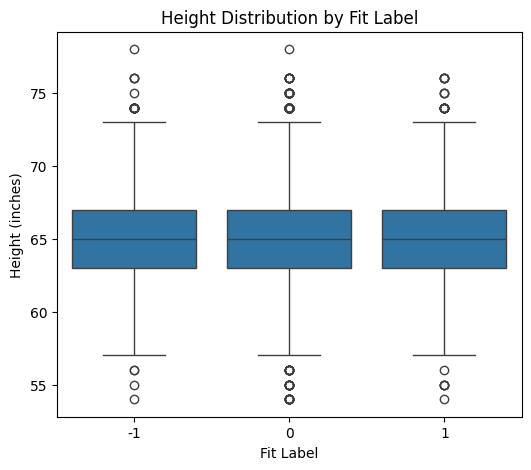

In [79]:
# Comparison of height vs fit
plt.figure(figsize=(6,5))
sns.boxplot(data=df_rent, x="fit", y="height_inches")
plt.title("Height Distribution by Fit Label")
plt.xlabel("Fit Label")
plt.ylabel("Height (inches)")
plt.show()

Height shows nearly no relationship with fit label, as all three categories (small=-1, fit=0, large=1) have nearly identical distributions with medians around 65 inches and similar spreads, suggesting height alone is not a strong predictor of clothing fit.

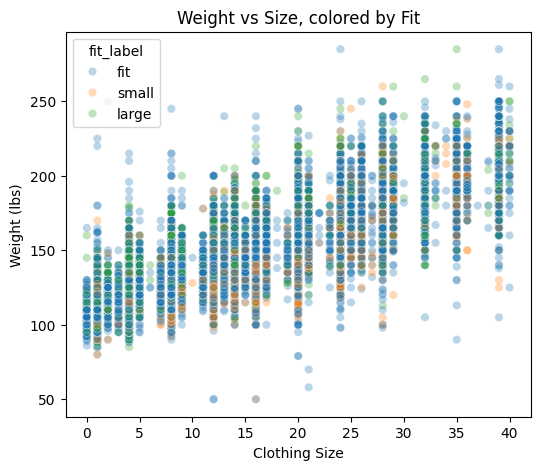

In [80]:
# Scatter plot of weight vs size
plt.figure(figsize=(6,5))
sns.scatterplot(data=df_rent, x="size", y="weight", hue="fit_label", alpha=0.3)
plt.title("Weight vs Size, colored by Fit")
plt.xlabel("Clothing Size")
plt.ylabel("Weight (lbs)")
plt.show()

The scatter plot above shows overlap of all three fit categories across the weight-size spectrum, with no clear separation between "fit" (blue), "small" (orange), and "large" (green) labels. This suggests that predicting fit requires additional features beyond just weight and size, such as body type, garment category, or body proportions.

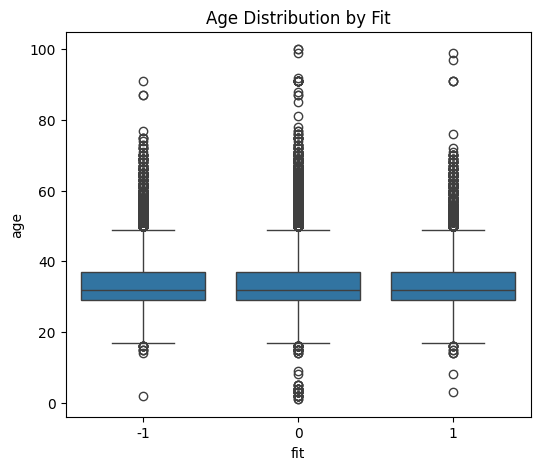

In [81]:
# Fit trends by age
plt.figure(figsize=(6,5))
sns.boxplot(data=df_rent, x="fit", y="age")
plt.title("Age Distribution by Fit")
plt.show()

The age distributions look very similar across all three fit categories, suggesting that age does not meaningfully influence whether an item runs small, true to size, or large.

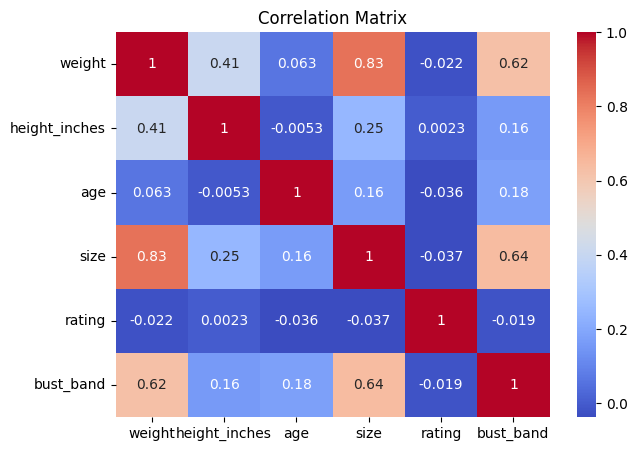

In [82]:
# Correlations of numeric features
numeric_cols = ["weight", "height_inches", "age", "size", "rating", "bust_band"]
corr = df_rent[numeric_cols].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

This correlation matrix above shows that weight has strong positive correlations with size (0.85) and bust_band (0.64). Most other variable pairs show weak correlations and the rating variable appears to be independent of physical measurements.

<Figure size 800x500 with 0 Axes>

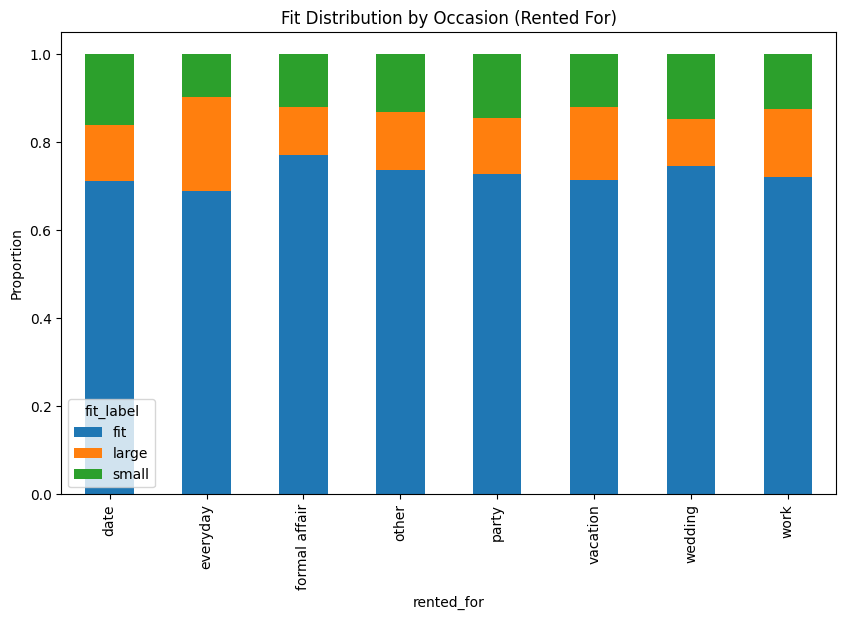

In [83]:
# Fit vs reason for renting
plt.figure(figsize=(8,5))
df_rent.groupby("rented_for")["fit_label"].value_counts(normalize=True).unstack().plot(
    kind="bar", stacked=True, figsize=(10,6)
)
plt.title("Fit Distribution by Occasion (Rented For)")
plt.ylabel("Proportion")
plt.show()


This stacked bar chart shows that across all rental occasions, the majority of items fit correctly with large being more common than small among the misfits. Fit proportions remain relatively consistent regardless of the event type.

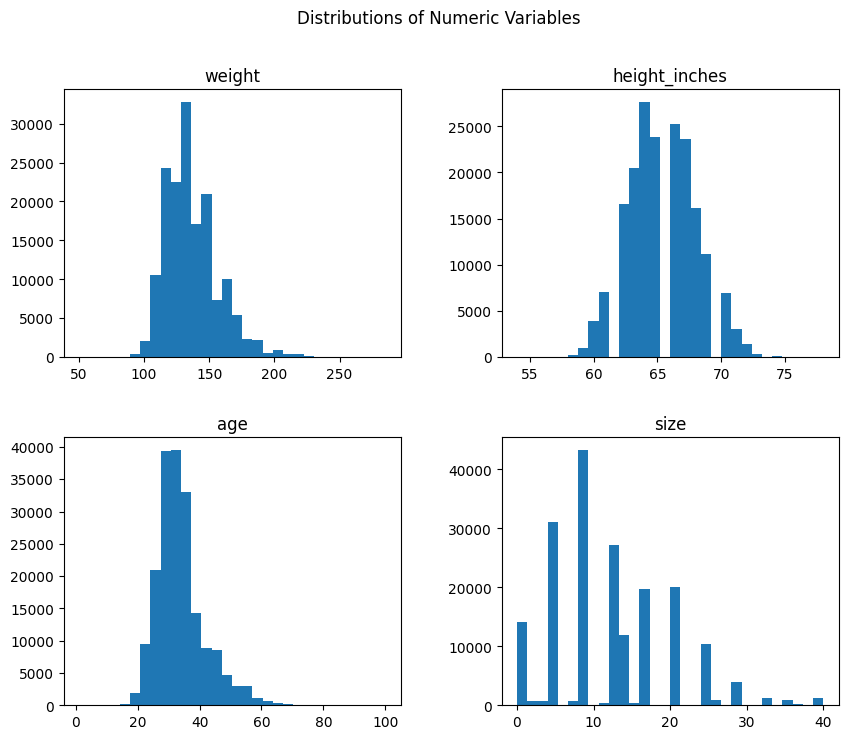

In [84]:
# Distribution of numeric features
df_rent[["weight","height_inches","age","size"]].hist(bins=30, figsize=(10,8), grid=False)
plt.suptitle("Distributions of Numeric Variables")
plt.show()

This figure shows the distributions of four numeric variables: weight is approximately normally distributed around 135 lbs, height clusters around 65-66 inches, age is right-skewed with most renters in their 30s, and size shows a  distribution with a peak smaller sizes around 8-10.

## Modeling

In [85]:
df_rent.head()

,fit,user_id,bust size,item_id,weight,rating,rented for,review_text,body type,review_summary,...,height,size,age,review_date,height_inches,bust_band,bust_cup,rented_for,category_clean,fit_label
0,0,420272,34d,2260466,137.0,10,vacation,An adorable romper! Belt and zipper were a lit...,hourglass,So many compliments!,...,"5' 8""",14,28,2016-04-20,68.0,34.0,D,vacation,jumpsuit/romper,fit
1,0,273551,34b,153475,132.0,10,other,I rented this dress for a photo shoot. The the...,straight & narrow,I felt so glamourous!!!,...,"5' 6""",12,36,2013-06-18,66.0,34.0,B,other,dress,fit
3,0,909926,34c,126335,135.0,8,formal affair,I rented this for my company's black tie award...,pear,Dress arrived on time and in perfect condition.,...,"5' 5""",8,34,2014-02-12,65.0,34.0,C,formal affair,dress,fit
4,0,151944,34b,616682,145.0,10,wedding,I have always been petite in my upper body and...,athletic,Was in love with this dress !!!,...,"5' 9""",12,27,2016-09-26,69.0,34.0,B,wedding,dress,fit
5,0,734848,32b,364092,138.0,8,date,Didn't actually wear it. It fit perfectly. The...,athletic,Traditional with a touch a sass,...,"5' 8""",8,45,2016-04-30,68.0,32.0,B,date,dress,fit


In [99]:
def prepare_features(df_rent):
    """
    Prepare features from the cleaned data
    """
    data = df_rent.copy()
    
    # Select numeric features
    numeric_features = ['weight', 'rating', 'age', 'height_inches', 'bust_band']
    
    # Select categorical features to encode
    categorical_features = ['body type', 'rented for', 'category_clean', 'size', 'bust_cup']

    # Drop rows with NaN
    all_features = numeric_features + categorical_features
    data = data.dropna(subset=all_features)
    
    # Encode categorical variables
    label_encoders = {}
    for col in categorical_features:
        le = LabelEncoder()
        data[col + '_encoded'] = le.fit_transform(data[col].astype(str))
        label_encoders[col] = le
    
    # Create feature list
    feature_cols = numeric_features + [col + '_encoded' for col in categorical_features]
    
    return data, feature_cols, label_encoders

In [100]:
def perform_kfold_cv(model, X, y, model_name, k=5, scale=False):
    """
    Perform k-fold cross-validation with multiple metrics
    """
    print(f"\nPerforming {k}-Fold Cross-Validation for {model_name}...")
    
    # Define stratified k-fold
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    
    # Define scoring metrics
    scoring = {
        'accuracy': 'accuracy',
        'precision_weighted': 'precision_weighted',
        'recall_weighted': 'recall_weighted',
        'f1_weighted': 'f1_weighted'
    }
    
    # Perform cross-validation
    if scale:
        # For logistic regression, scale within each fold
        cv_scores = {'accuracy': [], 'precision_weighted': [], 
                     'recall_weighted': [], 'f1_weighted': []}
        
        for train_idx, val_idx in skf.split(X, y):
            X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
            y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]
            
            # Scale data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_fold)
            X_val_scaled = scaler.transform(X_val_fold)
            
            # Train and predict
            model.fit(X_train_scaled, y_train_fold)
            y_pred = model.predict(X_val_scaled)
            
            # Calculate metrics
            cv_scores['accuracy'].append(accuracy_score(y_val_fold, y_pred))
            p, r, f, _ = precision_recall_fscore_support(y_val_fold, y_pred, 
                                                         average='weighted', zero_division=0)
            cv_scores['precision_weighted'].append(p)
            cv_scores['recall_weighted'].append(r)
            cv_scores['f1_weighted'].append(f)
        
        # Convert to arrays
        cv_results = {k: np.array(v) for k, v in cv_scores.items()}
    else:
        # For random forest, no scaling needed
        cv_results = cross_validate(model, X, y, cv=skf, scoring=scoring, 
                                     return_train_score=False, n_jobs=-1)
    
    # Calculate statistics
    results = {}
    for metric in ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        key = f'test_{metric}' if not scale else metric
        scores = cv_results[key] if not scale else cv_results[metric]
        results[metric] = {
            'mean': scores.mean(),
            'std': scores.std(),
            'scores': scores
        }
    
    return results

In [101]:
def train_and_compare_models(df_rent, target_col='fit_label', k_folds=5):
    """
    Train both Random Forest and Logistic Regression models using k-fold CV
    """
    print("="*70)
    print("PREPARING DATA")
    print("="*70)
    
    # Prepare features
    data, feature_cols, label_encoders = prepare_features(df_rent)
    
    # Prepare X and y
    X = data[feature_cols]
    y = data[target_col]
    
    print(f"\nDataset shape: {X.shape}")
    print(f"Number of features: {len(feature_cols)}")
    print(f"Target classes: {sorted(y.unique())}")
    print(f"\nClass distribution:")
    print(y.value_counts().sort_index())
    
    # Split data for final test set
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"\nTraining set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
    print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")
    
    # =====================
    # RANDOM FOREST MODEL
    # =====================
    print("\n" + "="*70)
    print(f"RANDOM FOREST WITH {k_folds}-FOLD CROSS-VALIDATION")
    print("="*70)
    
    rf_model = RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    # Perform k-fold CV on training data
    rf_cv_results = perform_kfold_cv(rf_model, X_train, y_train, "Random Forest", k=k_folds, scale=False)
    
    # Train final model on all training data
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"  Accuracy:  {rf_cv_results['accuracy']['mean']:.4f} ± {rf_cv_results['accuracy']['std']:.4f}")
    print(f"  Precision: {rf_cv_results['precision_weighted']['mean']:.4f} ± {rf_cv_results['precision_weighted']['std']:.4f}")
    print(f"  Recall:    {rf_cv_results['recall_weighted']['mean']:.4f} ± {rf_cv_results['recall_weighted']['std']:.4f}")
    print(f"  F1-Score:  {rf_cv_results['f1_weighted']['mean']:.4f} ± {rf_cv_results['f1_weighted']['std']:.4f}")
    print(f"\nFinal Test Set Accuracy: {accuracy_score(y_test, rf_pred):.4f}")
    
    # =====================
    # LOGISTIC REGRESSION MODEL
    # =====================
    print("\n" + "="*70)
    print(f"LOGISTIC REGRESSION WITH {k_folds}-FOLD CROSS-VALIDATION")
    print("="*70)
    
    lr_model = LogisticRegression(
        max_iter=1000,
        random_state=42,
        class_weight='balanced',
        solver='lbfgs',
        multi_class='multinomial'
    )
    
    # Perform k-fold CV on training data (with scaling)
    lr_cv_results = perform_kfold_cv(lr_model, X_train, y_train, "Logistic Regression", k=k_folds, scale=True)
    
    # Train final model on all training data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    lr_model.fit(X_train_scaled, y_train)
    lr_pred = lr_model.predict(X_test_scaled)
    
    print(f"\nCross-Validation Results (mean ± std):")
    print(f"  Accuracy:  {lr_cv_results['accuracy']['mean']:.4f} ± {lr_cv_results['accuracy']['std']:.4f}")
    print(f"  Precision: {lr_cv_results['precision_weighted']['mean']:.4f} ± {lr_cv_results['precision_weighted']['std']:.4f}")
    print(f"  Recall:    {lr_cv_results['recall_weighted']['mean']:.4f} ± {lr_cv_results['recall_weighted']['std']:.4f}")
    print(f"  F1-Score:  {lr_cv_results['f1_weighted']['mean']:.4f} ± {lr_cv_results['f1_weighted']['std']:.4f}")
    print(f"\nFinal Test Set Accuracy: {accuracy_score(y_test, lr_pred):.4f}")
    
    # =====================
    # MODEL COMPARISON
    # =====================
    print("\n" + "="*70)
    print("MODEL COMPARISON - K-FOLD CROSS-VALIDATION RESULTS")
    print("="*70)
    
    comparison = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Test Accuracy'],
        'Random Forest (CV)': [
            f"{rf_cv_results['accuracy']['mean']:.4f} ± {rf_cv_results['accuracy']['std']:.4f}",
            f"{rf_cv_results['precision_weighted']['mean']:.4f} ± {rf_cv_results['precision_weighted']['std']:.4f}",
            f"{rf_cv_results['recall_weighted']['mean']:.4f} ± {rf_cv_results['recall_weighted']['std']:.4f}",
            f"{rf_cv_results['f1_weighted']['mean']:.4f} ± {rf_cv_results['f1_weighted']['std']:.4f}",
            f"{accuracy_score(y_test, rf_pred):.4f}"
        ],
        'Logistic Regression (CV)': [
            f"{lr_cv_results['accuracy']['mean']:.4f} ± {lr_cv_results['accuracy']['std']:.4f}",
            f"{lr_cv_results['precision_weighted']['mean']:.4f} ± {lr_cv_results['precision_weighted']['std']:.4f}",
            f"{lr_cv_results['recall_weighted']['mean']:.4f} ± {lr_cv_results['recall_weighted']['std']:.4f}",
            f"{lr_cv_results['f1_weighted']['mean']:.4f} ± {lr_cv_results['f1_weighted']['std']:.4f}",
            f"{accuracy_score(y_test, lr_pred):.4f}"
        ]
    })
    
    print("\n" + comparison.to_string(index=False))
    
    # Determine better model based on CV accuracy
    rf_cv_acc = rf_cv_results['accuracy']['mean']
    lr_cv_acc = lr_cv_results['accuracy']['mean']
    
    print("\n" + "-"*70)
    if rf_cv_acc > lr_cv_acc:
        diff = rf_cv_acc - lr_cv_acc
        print(f"✓ Random Forest performs better")
        print(f"  CV Accuracy: {rf_cv_acc:.4f} vs {lr_cv_acc:.4f} (Δ = {diff:.4f})")
    elif lr_cv_acc > rf_cv_acc:
        diff = lr_cv_acc - rf_cv_acc
        print(f"✓ Logistic Regression performs better")
        print(f"  CV Accuracy: {lr_cv_acc:.4f} vs {rf_cv_acc:.4f} (Δ = {diff:.4f})")
    else:
        print(f"✓ Both models have equal CV accuracy: {rf_cv_acc:.4f}")
    print("-"*70)
    
    # =====================
    # FEATURE IMPORTANCE
    # =====================
    print("\n" + "="*70)
    print("FEATURE IMPORTANCE (RANDOM FOREST)")
    print("="*70)
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False).head(10)
    print("\nTop 10 Most Important Features:")
    print(feature_importance.to_string(index=False))
    
    # Return results
    results = {
        'rf_model': rf_model,
        'lr_model': lr_model,
        'scaler': scaler,
        'feature_cols': feature_cols,
        'label_encoders': label_encoders,
        'rf_cv_results': rf_cv_results,
        'lr_cv_results': lr_cv_results,
        'X_test': X_test,
        'y_test': y_test,
        'rf_pred': rf_pred,
        'lr_pred': lr_pred,
        'comparison': comparison
    }
    
    return results

In [102]:
results = train_and_compare_models(df_rent, k_folds=5)

PREPARING DATA

Dataset shape: (145394, 10)
Number of features: 10
Target classes: ['fit', 'large', 'small']

Class distribution:
fit_label
fit      107053
large     18904
small     19437
Name: count, dtype: int64

Training set size: 116315 (80.0%)
Test set size: 29079 (20.0%)

RANDOM FOREST WITH 5-FOLD CROSS-VALIDATION

Performing 5-Fold Cross-Validation for Random Forest...

Cross-Validation Results (mean ± std):
  Accuracy:  0.5721 ± 0.0027
  Precision: 0.6794 ± 0.0017
  Recall:    0.5721 ± 0.0027
  F1-Score:  0.6068 ± 0.0024

Final Test Set Accuracy: 0.5711

LOGISTIC REGRESSION WITH 5-FOLD CROSS-VALIDATION

Performing 5-Fold Cross-Validation for Logistic Regression...

Cross-Validation Results (mean ± std):
  Accuracy:  0.5954 ± 0.0037
  Precision: 0.6555 ± 0.0017
  Recall:    0.5954 ± 0.0037
  F1-Score:  0.6203 ± 0.0029

Final Test Set Accuracy: 0.5965

MODEL COMPARISON - K-FOLD CROSS-VALIDATION RESULTS

       Metric Random Forest (CV) Logistic Regression (CV)
     Accuracy    0.

In [105]:
rf_model = results['rf_model']
rf_model

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=4, min_samples_split=10, n_jobs=-1,
                       random_state=42)

In [106]:
lr_model = results['lr_model']
lr_model

LogisticRegression(class_weight='balanced', max_iter=1000,
                   multi_class='multinomial', random_state=42)